# Model Training

In [1]:
# XGBoost Model Training with Absolute Path
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# ==============================
# 1. Load the processed dataset
# ==============================
data_path = r"C:\Users\haier\AI_Stock_Analyzer\Data\processed\all_stocks_features.csv"

if not os.path.exists(data_path):
    raise FileNotFoundError(f"Processed dataset not found at: {data_path}")

df = pd.read_csv(data_path, parse_dates=["Date"])
print("Data loaded successfully!")
print("Shape:", df.shape)
print(df.head())

# ==============================
# 2. Prepare features & target
# ==============================
target = "Close"
features = [col for col in df.columns if col not in ["Date", "Ticker", target]]

X = df[features]
y = df[target].values.ravel()  # ensure y is 1D

print("X shape:", X.shape)
print("y shape:", y.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# ==============================
# 3. Train XGBoost Model
# ==============================
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:squarederror"
)

print("\nTraining XGBoost model...")
xgb_model.fit(X_train, y_train)

# ==============================
# 4. Evaluate XGBoost Model
# ==============================
def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"\n{name} Evaluation:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    return y_pred

y_pred_xgb = evaluate_model(xgb_model, X_test, y_test, "XGBoost")

# ==============================
# 5. Save XGBoost Model
# ==============================
models_folder = r"C:\Users\haier\AI_Stock_Analyzer\models"
os.makedirs(models_folder, exist_ok=True)

xgb_model_path = os.path.join(models_folder, "generalized_model.pkl")  # renamed for consistency
joblib.dump(xgb_model, xgb_model_path)

print(f"\nXGBoost model saved at: {xgb_model_path}")


Data loaded successfully!
Shape: (9990, 22)
        Date       Open       High        Low      Close       Volume  \
0 2017-01-24  29.887501  30.025000  29.875000  29.992500   92844000.0   
1 2017-01-25  30.105000  30.525000  30.070000  30.469999  129510400.0   
2 2017-01-26  30.417500  30.610001  30.400000  30.485001  105350400.0   
3 2017-01-27  30.535000  30.587500  30.400000  30.487499   82251600.0   
4 2017-01-30  30.232500  30.407499  30.165001  30.407499  121510000.0   

       MA10  MA50  MA200      EMA10  ...  Volatility  Momentum        RSI  \
0  29.92425   NaN    NaN  29.863754  ...         NaN  0.245001  81.006434   
1  29.99350   NaN    NaN  29.973981  ...         NaN  0.692499  86.901756   
2  30.04825   NaN    NaN  30.066893  ...         NaN  0.547501  85.964907   
3  30.11575   NaN    NaN  30.143367  ...         NaN  0.674999  83.006507   
4  30.18050   NaN    NaN  30.191391  ...         NaN  0.647499  74.626857   

       MACD  MACD_signal       ATR  Close_lag1  Close_


📊 Top 15 Most Important Features (by Gain):

    Feature    Importance
        Low 261491.187500
       High 219452.781250
      MA200  24010.054688
       Open   7917.221680
      EMA10   4810.472656
 Close_lag1   4200.936523
 Close_lag2   2408.441162
       MA10   2309.028320
       MA50   1612.874146
 Close_lag3   1071.898071
      EMA50    833.328552
     Return     22.863447
       MACD     10.149699
MACD_signal      9.070914
   Momentum      8.460048


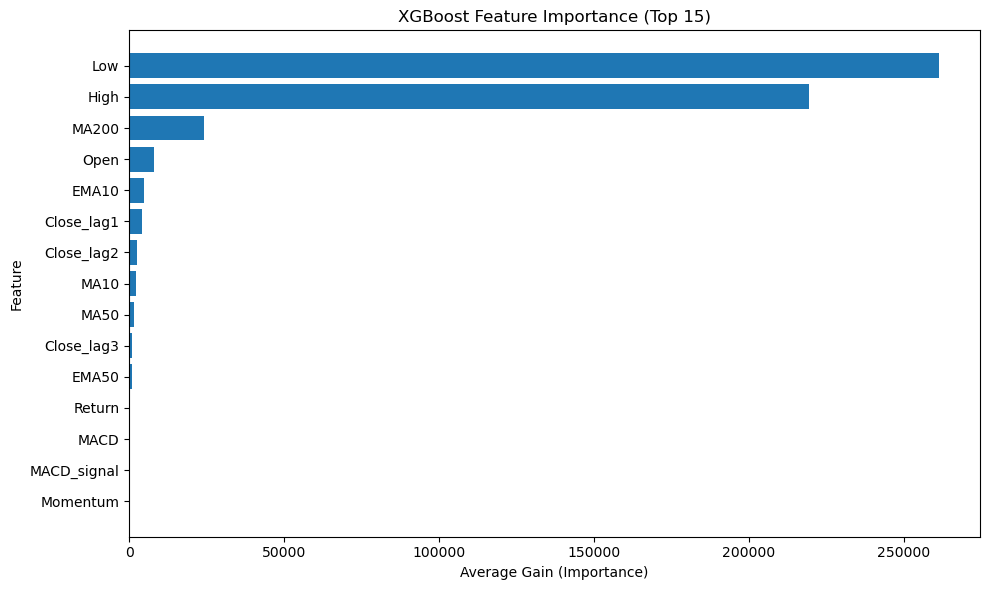

In [7]:
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb

# 1. Build absolute path safely
base_dir = r"C:\Users\haier\AI_Stock_Analyzer"
model_path = os.path.join(base_dir, "models", "generalized_model.pkl")

# 2. Verify file existence
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model not found at: {model_path}")

# 3. Load model
with open(model_path, "rb") as f:
    model = pickle.load(f)

# 4. Extract feature importances using booster directly
booster = model.get_booster()
importance_dict = booster.get_score(importance_type="gain")

# Convert to DataFrame for sorting
importance_df = pd.DataFrame(
    list(importance_dict.items()), 
    columns=["Feature", "Importance"]
).sort_values(by="Importance", ascending=False)

# Show top features as a table
print("\n📊 Top 15 Most Important Features (by Gain):\n")
print(importance_df.head(15).to_string(index=False))

# 5. Plot nicely using Matplotlib
top_n = 15
plt.figure(figsize=(10, 6))
plt.barh(
    importance_df["Feature"].head(top_n)[::-1], 
    importance_df["Importance"].head(top_n)[::-1]
)
plt.xlabel("Average Gain (Importance)")
plt.ylabel("Feature")
plt.title(f"XGBoost Feature Importance (Top {top_n})")
plt.tight_layout()
plt.show()


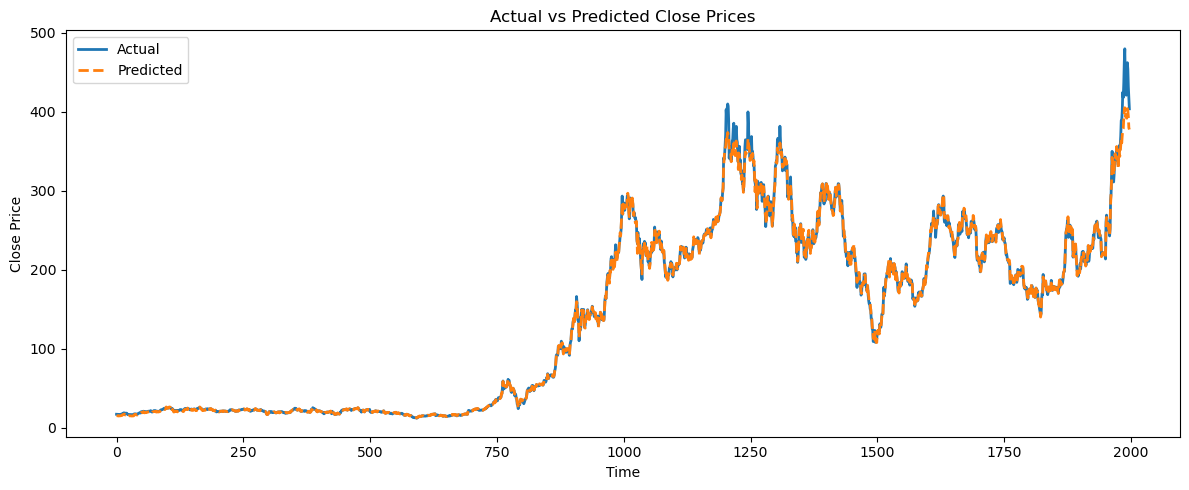

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual", linewidth=2)
plt.plot(y_pred, label="Predicted", linewidth=2, linestyle="dashed")
plt.legend()
plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.tight_layout()
plt.show()


In [3]:
import numpy as np

# Compute actual and predicted daily returns
actual_direction = np.sign(y_test[1:] - y_test[:-1])      # +1 if up, -1 if down
xgb_direction = np.sign(y_pred_xgb[1:] - y_test[:-1])     # XGBoost prediction direction

# Compute directional accuracy
xgb_acc = np.mean(actual_direction == xgb_direction) * 100

print(f"XGBoost Directional Accuracy: {xgb_acc:.2f}%")


XGBoost Directional Accuracy: 84.23%


________________________________________________________________________________________________________________________________________________________

In [8]:
import joblib

# Load XGBoost model only
models_folder = r"C:\Users\haier\AI_Stock_Analyzer\models"
xgb_model = joblib.load(f"{models_folder}/generalized_model.pkl")

# -----------------------------
# Features used by XGBoost
# -----------------------------
print("XGBoost Features:")
if hasattr(xgb_model, "get_booster"):
    booster = xgb_model.get_booster()
    xgb_features = booster.feature_names
    print(xgb_features)
else:
    print("No feature names found in XGBoost model.")


XGBoost Features:
['Open', 'High', 'Low', 'Volume', 'MA10', 'MA50', 'MA200', 'EMA10', 'EMA50', 'Return', 'Volatility', 'Momentum', 'RSI', 'MACD', 'MACD_signal', 'ATR', 'Close_lag1', 'Close_lag2', 'Close_lag3']


In [15]:
import yfinance as yf
import pandas as pd

ticker = "TSLA"
data = yf.download(ticker, period="1y", interval="1d", auto_adjust=False)

print("Columns in data:", data.columns)


[*********************100%***********************]  1 of 1 completed

Columns in data: MultiIndex([('Adj Close', 'TSLA'),
            (    'Close', 'TSLA'),
            (     'High', 'TSLA'),
            (      'Low', 'TSLA'),
            (     'Open', 'TSLA'),
            (   'Volume', 'TSLA')],
           names=['Price', 'Ticker'])
